open View --> Cell Toolbar --> Slideshow

# Seahorse: Machine Learning for Stock Trading


Date: 2019-04-26

**Partner**: Webster, Collin

**Team Member**:

- Chiu, Simon
- Lei, Gilbert
- Wu, Fan
- Yu, Linyang

**Mentor**: Lourenzutti, Rodolfo



# Introduction to Oscillator

Oscillators are indicators that are used when viewing charts that are non-trending.

- Generating buy or sell signal to provide advice to the users;

<img src = "img/indic2-rsi-ibm.png">


*example for typical Oscillator, from "Introduction to Technical Indicators and Oscillators"

# Introduction to Oscillator

Oscillators are indicators that are used when viewing charts that are non-trending.

- Generating buy or sell signal to provide advice to the users;
- The key is the users' own human judgment: reading indicators is more of an art than science.

<img src = "img/indic1-rmbs.png">

*example for typical Oscillator, from "Introduction to Technical Indicators and Oscillators"

# Project Goal

- Our main goal would be translating human judgment to the computer language, combining that information with other data resources, and providing a model to evaluate the reliabilities of the signals given by the Oscillator. 

# Objectives

- Exploratory data analysis (EDA): during this process, we will focus on the original data resources provided by our partner.
    > - Explore the relationship among the time series of Oscillator, stock price, and MACD;
    > - Explore other possible features/indicators directly or indirectly connected to the "true" signal;
    > - Explore the effectiveness of the human judgment given by our partner based on his knowledge;
    > - Summarize all the possible indicators/predictors that we can use to train our model convincingly.
   

- Exploring possible models to address our problem: our basic strategies should be based on machine learning

- Exceptional and outlier handling based on the output of our model: during this process, the models from the last step will be tested repeatedly. We will be focusing on identifying the outliers and other exceptional situations and modifying our model based on the findings.

# Exploratory data analysis (EDA)

In [132]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for statistics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# others
import random
import time

df = pd.read_csv("data/buy/acad1Buy3ML10years.txt", delimiter="\s+", header = None)

osc = df.iloc[21:, 0:41]
stk = df.iloc[21:, 41:82]
macd = df.iloc[21:, 82:123]
rtn = df.iloc[21:, 123]
label = np.sign(rtn)
label = label.map({1: 1, -1: 0, 0:0})
results = label.map({1: 'EARN', -1: 'LOSS', 0: 'LOSS'})

#df_remove_rtn = df.iloc[21:,0:123]

def EDA(df, osc_ind = True, stk_ind = True, macd_ind = True, style = 'bmh', figsize=(7,7)):
    index = 60
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        num_layout = np.sum([osc_ind, stk_ind, macd_ind])
        layout = (num_layout, 1)

        if osc_ind:
            osc_ax = plt.subplot2grid(layout, (0, 0))
            osc_ax.plot(range(41), osc.iloc[index,:])
            osc_ax.invert_xaxis()
            plt.hlines(0, xmin=0, xmax=40, colors='k',linestyles = "dashed")
            osc_ax.set_title('Oscillator 3-Day Time Series')
            osc_ax.set_xlabel('Time')
            osc_ax.set_ylabel('Oscillator')
        
        if stk_ind:
            stk_ax = plt.subplot2grid(layout, (1, 0))
            stk_ax.plot(range(41), stk.iloc[index,:])
            stk_ax.invert_xaxis()
            stk_ax.set_title('Stock Price 3-Day Time Series')
            stk_ax.set_xlabel('Time')
            stk_ax.set_ylabel('Stock Price')
        
        if macd_ind:
            macd_ax = plt.subplot2grid(layout, (2, 0))
            macd_ax.plot(range(41), macd.iloc[index,:])
            macd_ax.invert_xaxis()
            plt.hlines(0, xmin=0, xmax=40, colors='k', linestyles = "dashed")
            macd_ax.set_title('MACD 3-Day Time Series')
            macd_ax.set_xlabel('Time')
            macd_ax.set_ylabel('MACD')
        
        
        plt.tight_layout()
        
    

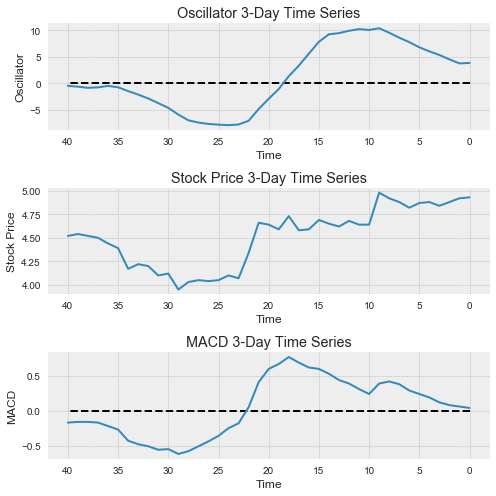

In [133]:
EDA(df)

In [138]:
def tsplot(y, lags=None, figsize=(10, 5), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        
        y.plot(ax=ts_ax)
        ts_ax.invert_xaxis()
        ts_ax.hlines(0, xmin=0, xmax=40, colors='k', linestyles = "dashed")
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

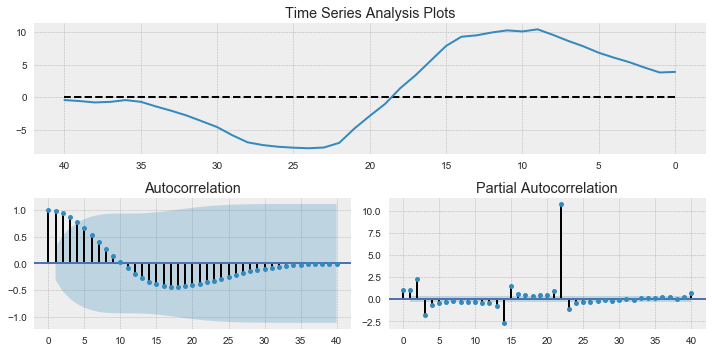

In [139]:
tsplot(osc.iloc[60,:], lags=40)

In [116]:
# Group data readin
df_gp = pd.DataFrame()
for filename in os.listdir('data/buy/'):
    if filename.endswith(".txt"): 
        stock = filename[0:4]
        # print("Loading stock data:", stock, ",")
        temp_df = pd.read_csv(os.path.join('data/buy/', filename), delimiter= '\s+', header = None)
        temp_df.rename(columns={123:'rtn'}, inplace=True)
        temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
        df_gp = pd.concat([df_gp, temp_df])
        continue
    else:
        continue
        
name_gp = df_gp.iloc[21:, 0]
osc_gp = df_gp.iloc[21:, 1:42]
stk_gp = df_gp.iloc[21:, 42:83]
macd_gp = df_gp.iloc[21:, 83:124]
rtn_gp = df_gp.iloc[21:, 124]
label_gp = np.sign(rtn_gp)
label_gp = label_gp.map({1: 1, -1: 0, 0:0})
results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})

osc_gp2 = round(osc_gp.iloc[:, 0],-1)
osc_gp2 = pd.Series(osc_gp2, name = 'OSC_grp')
osc_mag_to_lbl_analysis_df = pd.concat([name_gp, osc_gp2, label_gp],axis=1)
osc_grp_plot = osc_mag_to_lbl_analysis_df.groupby(['stock','OSC_grp']).mean().reset_index()

def osc_plot():
    with plt.style.context('bmh'):    
        fig = plt.figure(figsize=(10, 7))
        layout = (1, 1)
        ax = plt.subplot2grid(layout, (0, 0))
        sns.boxplot(ax=ax, x='OSC_grp', y='rtn', data=osc_grp_plot)
        plt.xlabel("amplitude of the OSC values")
        plt.ylabel("return value (gain/loss)")
        plt.tight_layout()

# Buy-Earn by amplitude of the OSC values

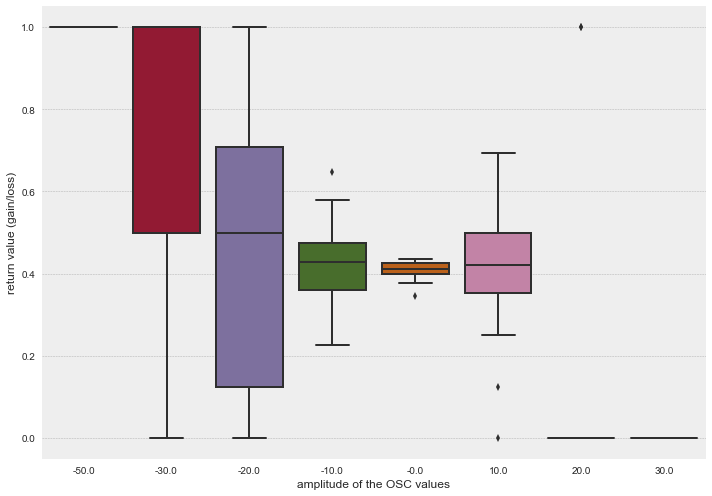

In [117]:
# code needed for the boxplot
osc_plot()

# Buy-Earn by MACD

In [118]:
def macd_plots():
    macd_0 = []
    macd_timepoint = []
    rec_label = []
    rec_rtn = []
    for i in range(osc.shape[0]):
        
        data_osc = osc_gp.iloc[i,:]
        data_macd = macd_gp.iloc[i,:]
        data_label = label_gp.iloc[i]
        data_rtn = rtn_gp.iloc[i]

    # return how many macd values are equal to 0
        macd_0.append(sum(data_macd ==0))
       
    # return the distance between the signal and nearest time points that macd recorded as 0
        macd_timepoint.append(123 - np.argmax(data_macd == 0))

        rec_label.append(data_label)
        rec_rtn.append(data_rtn)

# construct the final record data frame
    df_macd = pd.DataFrame({"macd_0": macd_0,
                       "distance_from_signal": macd_timepoint,
                       "label": rec_label,
                       "rtn":rec_rtn})
    
    df_macd_ro = df_macd.loc[df_macd['rtn'] < 25]

    df_macd_0 = df_macd_ro.loc[df_macd_ro['macd_0'] < 5]
    
    df_macd_tp = df_macd_ro.loc[df_macd_ro['distance_from_signal'] > 35]

    with plt.style.context("bmh"):
        fig = plt.figure(figsize = (23.4, 16.5))
        layout = (2,2)
        
        ax1 = plt.subplot2grid(layout, (0,0))
        sns.boxplot(ax = ax1, x = "macd_0", y = "rtn", data = df_macd_ro)
        plt.xlabel("# of MACD = 0 before signal")
        plt.ylabel("return value (gain/loss)")
    
    
        #ax2 = plt.subplot2grid(layout, (1,0))
        #sns.boxplot(ax = ax2, x = "macd_0", y = "rtn", data = df_macd_0)
        #plt.xlabel("# of MACD = 0 before signal")
        #plt.ylabel("return value (gain/loss)")
        
    
        ax3 = plt.subplot2grid(layout, (0,1))
        sns.boxplot(ax = ax3, x = "distance_from_signal", y = "rtn", data = df_macd_ro).invert_xaxis()
        plt.xlabel("distance between signal and the nearest point for MACD=0")
        plt.ylabel("return value (gain/loss)")
    
        ax3 = plt.subplot2grid(layout, (1,1))
        sns.boxplot(ax = ax3, x = "distance_from_signal", y = "rtn", data = df_macd_tp).invert_xaxis()
        plt.xlabel("distance between signal and the nearest point for MACD=0")
        plt.ylabel("return value (gain/loss)")
    

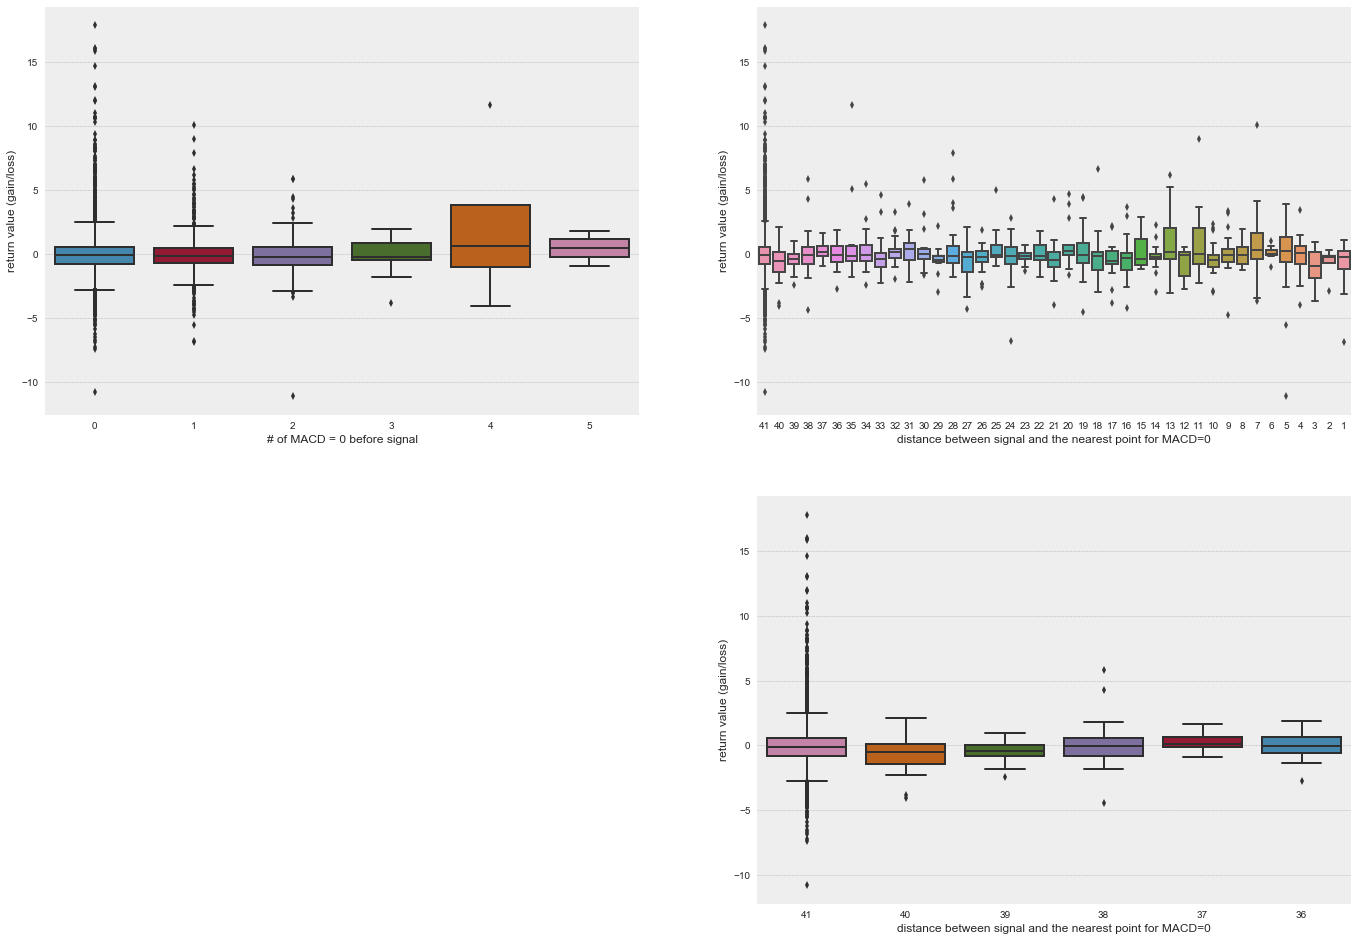

In [119]:
macd_plots()

# Baseline Model


In [114]:
classifiers = {
    #'knn'           : KNeighborsClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=50),
    #'naive bayes': MultinomialNB(),
    #'decision tree' : DecisionTreeClassifier(),
    'Logistic Regression'  : LogisticRegression(multi_class="multinomial", solver="lbfgs"),
    'SVM' : SVC(C=100, gamma="scale")
}

def precision_pipline(model, feature_matrix, test_size = 0.2):    
   #Split test set
    X, X_test, y, y_test = train_test_split(feature_matrix, label, test_size=test_size)

    #Split train/validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
    
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    
    pred = model.predict(X_test)
    true = y_test
    df_ana = pd.DataFrame({"pred":pred,
                          "true":true})
    test_precision = sum(df_ana['true'] & df_ana['pred'])/sum(df_ana['pred'])

    return train_acc, test_acc, test_precision


def model_fitting_pipline(feature_matrix, running_time=20):
    train_scores = dict()
    test_scores = dict()
    test_precisions = dict()
    training_times = dict()

    for classifier_name, classifier_obj in classifiers.items():
        print("Fitting", classifier_name)
        m_train_acc = []
        m_test_acc = []
        m_test_precision = []
        m_train_time = []
        for i in range(running_time):
            t = time.time()
            train_acc, test_acc, test_precision = precision_pipline(classifier_obj, feature_matrix)
            
            m_train_acc.append(train_acc)
            m_test_acc.append(test_acc)
            m_test_precision.append(test_precision)
            m_train_time.append(time.time() - t)

        training_times[classifier_name] = np.mean(m_train_time)
        train_scores[classifier_name] = np.mean(m_train_acc)
        test_scores[classifier_name] = np.mean(m_test_acc)
        test_precisions[classifier_name] = np.mean(m_test_precision)

    pd.options.display.float_format = '{:,.4f}'.format
    data = {"Train Accuracy": train_scores, 
            "Test Accuracy" : test_scores, 
            "Test Precision": test_precisions, 
            "Training Time(s)" : training_times}
    result_df = pd.DataFrame(data, columns=data.keys())
    result_df.index = list(classifiers.keys())
    return result_df



In [115]:
bm2_matrix = pd.concat([osc, stk, macd], axis=1)
model_fitting_pipline(bm2_matrix)

Fitting Random Forest
Fitting Logistic Regression
Fitting SVM


,Train Accuracy,Test Accuracy,Test Precision,Training Time(s)
Random Forest,0.6561,0.6356,0.4321,0.1225
Logistic Regression,0.9998,0.6144,0.3989,1.0525
SVM,0.8128,0.6155,0.4123,2.3897


# Timeline

| Milestone | Deliverable | Target Date |
| --- | --- | --- |
| Finish proposal presentation | Proposal presentation deck | Apr 26th, 2019 |
| Finish project proposal | Project proposal | May 3rd, 2019 |
| Finalize model selection | NA | May 17th, 2019 |
| Finalize proof-of-concept model | NA | May 24th, 2019 |
| Finish final presentation | Final presentation deck | Jun 18th, 2019 |
| Finish final report | Final report | Jun 26th, 2019 |
| Finish final data product | Final data product | Jun 26th, 2019 |

# Challenges we are facing and will face


- Correlation between our source data;

- The trade-off between sensitivity and consistency;

- Using loss function focusing on precision. 

# Thank You



# Q&A

This are the slides prepared for Q&A


<img src = "https://d.stockcharts.com/school/data/media/chart_school/technical_indicators/introduction_to_technical_indicators_and_oscillators/indic3-sso-rsi.png">